# Understanding convolution

## Installing and Importing libraries

In [1]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 36.2 MB/s eta 0:00:00


In [271]:
import os
import numpy as np
import skimage
import pydicom as dicom
import matplotlib.pyplot as plt
import scipy
# these are common libraries for image processing: Skimage, Pillow, and CV2, which is the python version for open cv
from PIL import Image
from skimage import exposure
from skimage.util import random_noise
import cv2
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 6)

## Set Up and Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [272]:
%pwd # print current directory

'/content/drive/MyDrive/NECST/PiA/Lezione2'

In [273]:
# Change and navigate to the desired directory
%cd drive/MyDrive/NECST/PiA/Lezione2/

[Errno 2] No such file or directory: 'drive/MyDrive/NECST/PiA/Lezione2/'
/content/drive/MyDrive/NECST/PiA/Lezione2


In [274]:
# another way you can change directory is by leveraging OS
os.chdir("images")
print(f"current directory: {os.getcwd()}")

current directory: /content/drive/MyDrive/NECST/PiA/Lezione2/images


In [275]:
# now go back of one directory
os.chdir("..")
print(f"current directory: {os.getcwd()}")

current directory: /content/drive/MyDrive/NECST/PiA/Lezione2


In [276]:
# Check what's inside the diectory
%ls

images/  Lecture2.pptx  Lezione2.ipynb


## Utilitary Functions

### Show images

In [39]:
def show(img, title = None, cmap = 'gray'):
  """Utility function to display images"""
  fig = plt.figure(figsize = (10, 8))
  plt.imshow(img)
  plt.axis("off")
  if title is not None:
    plt.title(title)
  plt.show()

### Prepare images

Now we prepare images to play with


In [36]:
def generate_square(size=128, box=(32, 32, 96, 96)):
    """Create a square shape on black background; box=(y0, x0, y1, x1)."""
    # create a 3 channel image
    img = np.zeros((size, size, 3), dtype=np.float32)
    y0, x0, y1, x1 = box
    img[y0:y1, x0:x1] = 1.0
    # create a larger box around this first one
    y0, x0, y1, x1 = y0-10, x0-10, y1+10, x1+10
    # display it in red
    img[y0:y1, x0:x1, 0] = 1.

    return img


## Image loading

(1151, 1920)


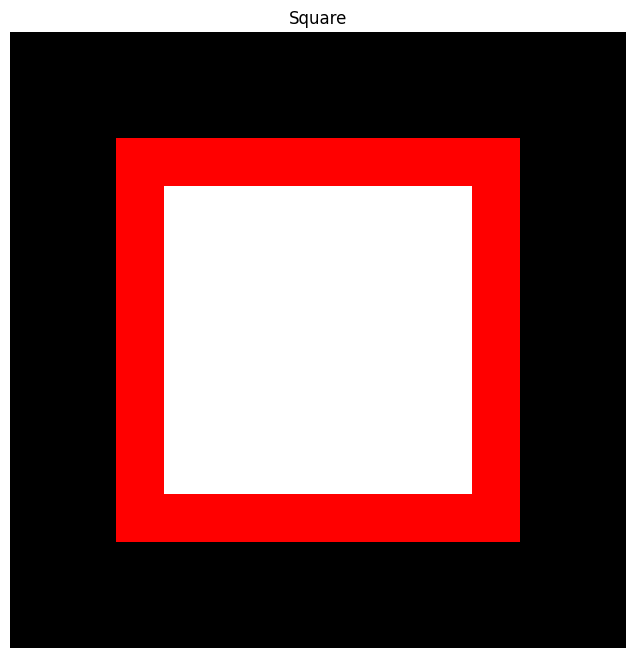

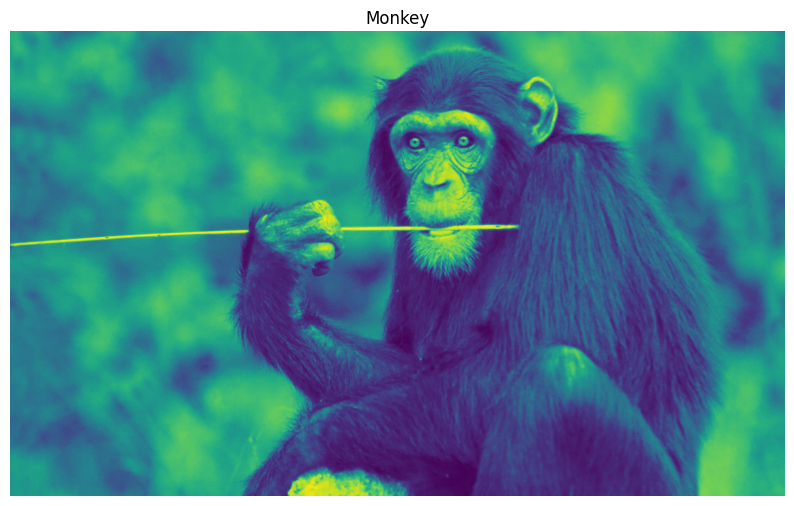

In [289]:
%pwd
# generate one syntethic image
img_sq = generate_square()
img_monkey  = cv2.imread("images/image_rgb.tiff")
img_monkey = cv2.cvtColor(img_monkey, cv2.COLOR_BGR2RGB)
img_monkey = img_monkey[:, :, 0]
print(img_monkey.shape)


show(img_sq, "Square")
show(img_monkey, "Monkey")

In [279]:
# We can print images types


## Convolution

A convolution is a mathematical operation on two objects, an input information and a kernel, to produce an outcome that expresses how the shape of one is modified by the other.

<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*LkBTMMY49OTF-I84yESMjQ.png" width="500">

Since the RGB and greyscale channels of an image are in 2D dimensions, the kernel of a convolution that operates in the image domain has the form of a 2D matrix.

2D convolution combines an input image with a small kernel to produce a third array thath highlights specific features of the input.
The kernel slides over the image, multiplying overlapping elements, and summing the products to produce each output value.

The output of a convolution operation is called a feature map, while the convolution kernel is often referred to as the filter, channel or feature detector of a convolution.

<img src="https://courses.cs.washington.edu/courses/cse446/21au/sections/08/correlation.png" width="400">

Fundamental properties of convolution are:
- **Sparse**: few input units contribute to each output
- **Parameter reuse**: the same kernel weights are applied to multiple locations of the input
- **Preserves the notion of ordering**:  it maps local neighborhoods in the input to nearby locations in the output, keeping spatial/temporal adjacency intact. Nearby inputs stay nearby in the output.

Mathematically for 2D: \[
(I * K)[i,j] = \sum_{u}\sum_{v} I[i - u,\; j - v]\; K[u,v]
\] (with appropriate handling at borders via padding).
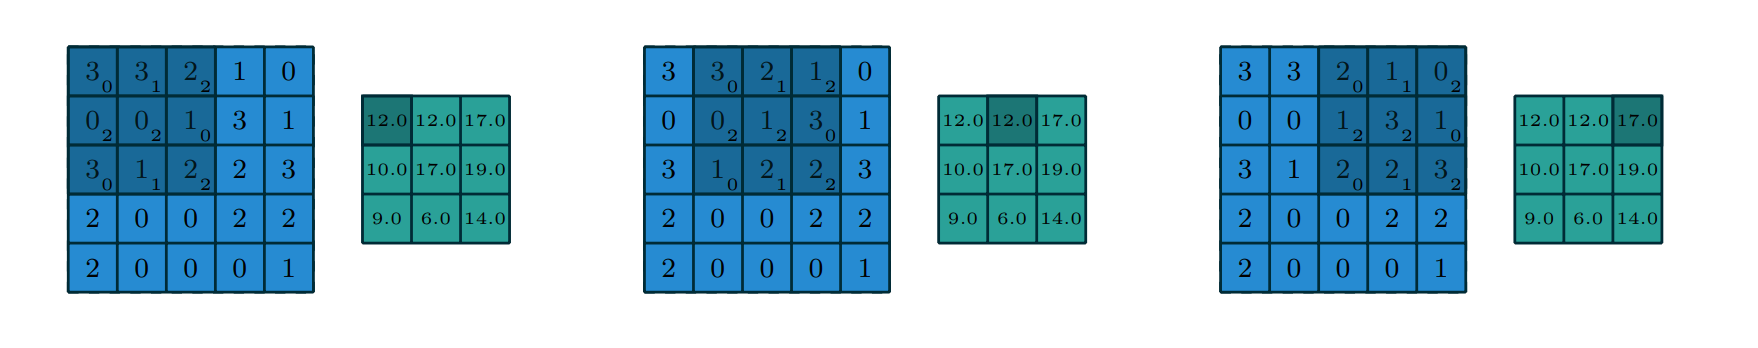

Picture taken from: [A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285)

## Handcrafted convolution

In [73]:
def conv2d(img, kernel, stride=1, padding=0):
    """
    Implementation of 2D convolution.
    -img: 2D array (H, W) or 3D array (H, W, C)
    -kernel: 2D array (m, n)
    -stride: integer, step of the sliding window
    -padding: integer, number of zeros to add to each side
    """
    original_ndim = img.ndim
    if original_ndim == 2:
        img = np.expand_dims(img, axis=2)

    M, N, C = img.shape
    m, n = kernel.shape

    # apply padding
    if padding > 0:
        img_padded = np.pad(img, ((padding, padding), (padding, padding), (0, 0)), 'constant')
    else:
        img_padded = img

    # get new image dimensions
    M_pad, N_pad, _ = img_padded.shape

    # output dimensions
    outH = (M_pad - m) // stride + 1
    outW = (N_pad - n) // stride + 1

    out = np.zeros((outH, outW, C))

    kernel_exp = np.expand_dims(kernel, axis=2) # (m, n, 1)

    for ii in range(outH):
        for jj in range(outW):

            # compute local neighborhood of action, keeping into accound stride
            h_start = ii * stride
            h_end = h_start + m
            w_start = jj * stride
            w_end = w_start + n

            out[ii, jj, :] = np.sum(kernel_exp * img_padded[h_start:h_end, w_start:w_end, :], axis=(0, 1))

    if original_ndim == 2:
        return np.squeeze(out, axis=2)
    else:
        return out # (outH, outW, C)

In [280]:
# We make the filter as made of 1s
filt=np.ones ((5,5))/25 # It is like taking the mean of the image
print (filt)

# We can make another filter that is bigger than the first one
filt1=np.ones ((19,19))
# Making sure to normalize the kernel
filt1/= (np.sum(filt1)+1e-6)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


Now we apply Conv2D to our image. You can see the presence of a blurring, because the starting image did not have any noise

(124, 124, 3)


Text(0.5, 1.0, 'Blurred')

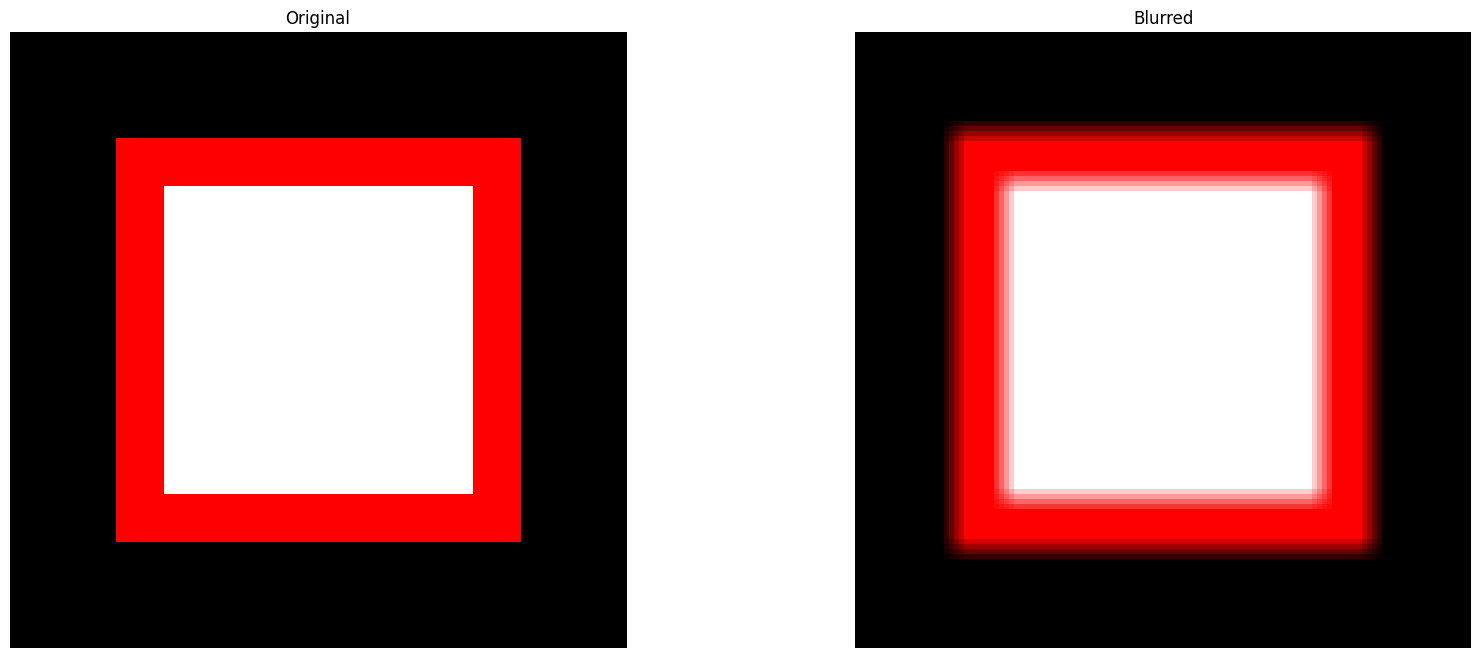

In [281]:
output_sq = conv2d(img_sq, filt)
print(output_sq.shape)
fig = plt.figure(figsize=(20,8))
fig.add_subplot(1, 2, 1)
plt.imshow(img_sq)
plt.axis("off")
plt.title("Original")
fig.add_subplot(1, 2, 2)
plt.imshow(output_sq)
plt.axis("off")
plt.title("Blurred")

## What happens if we use a smaller or a larger filter

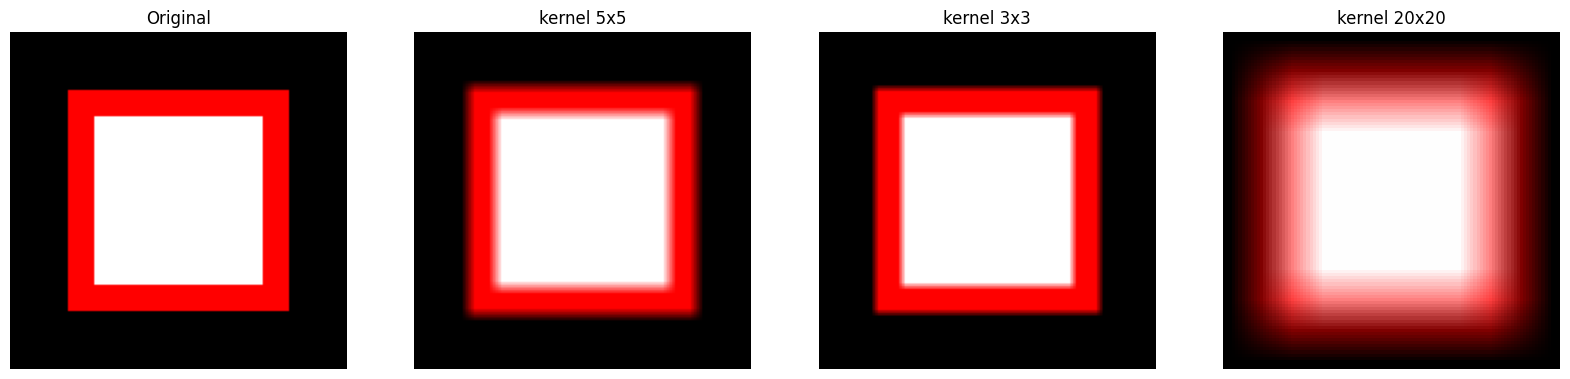

In [290]:
# Smaller
filt1 = np.ones((3, 3)) / 9
# Larger
filt2 = np.ones((20, 20)) / 400

out1 = conv2d(img_sq, filt1)

out2 = conv2d(img_sq, filt2)

fig = plt.figure(figsize=(20,8))
fig.add_subplot(1, 4, 1)
plt.imshow(img_sq)
plt.axis("off")
plt.title("Original")
fig.add_subplot(1, 4, 2)
plt.imshow(output_sq)
plt.title("kernel 5x5")
plt.axis("off")
fig.add_subplot(1, 4, 3)
plt.imshow(out1)
plt.title("kernel 3x3")
plt.axis("off")
fig.add_subplot(1, 4, 4)
plt.imshow(out2)
plt.axis("off")
plt.title("kernel 20x20")
plt.show()




output dimension with stride = 1: (124, 124, 3)
output dimension with stride = 2: (62, 62, 3)
output dimension with stride = 4: (31, 31, 3)


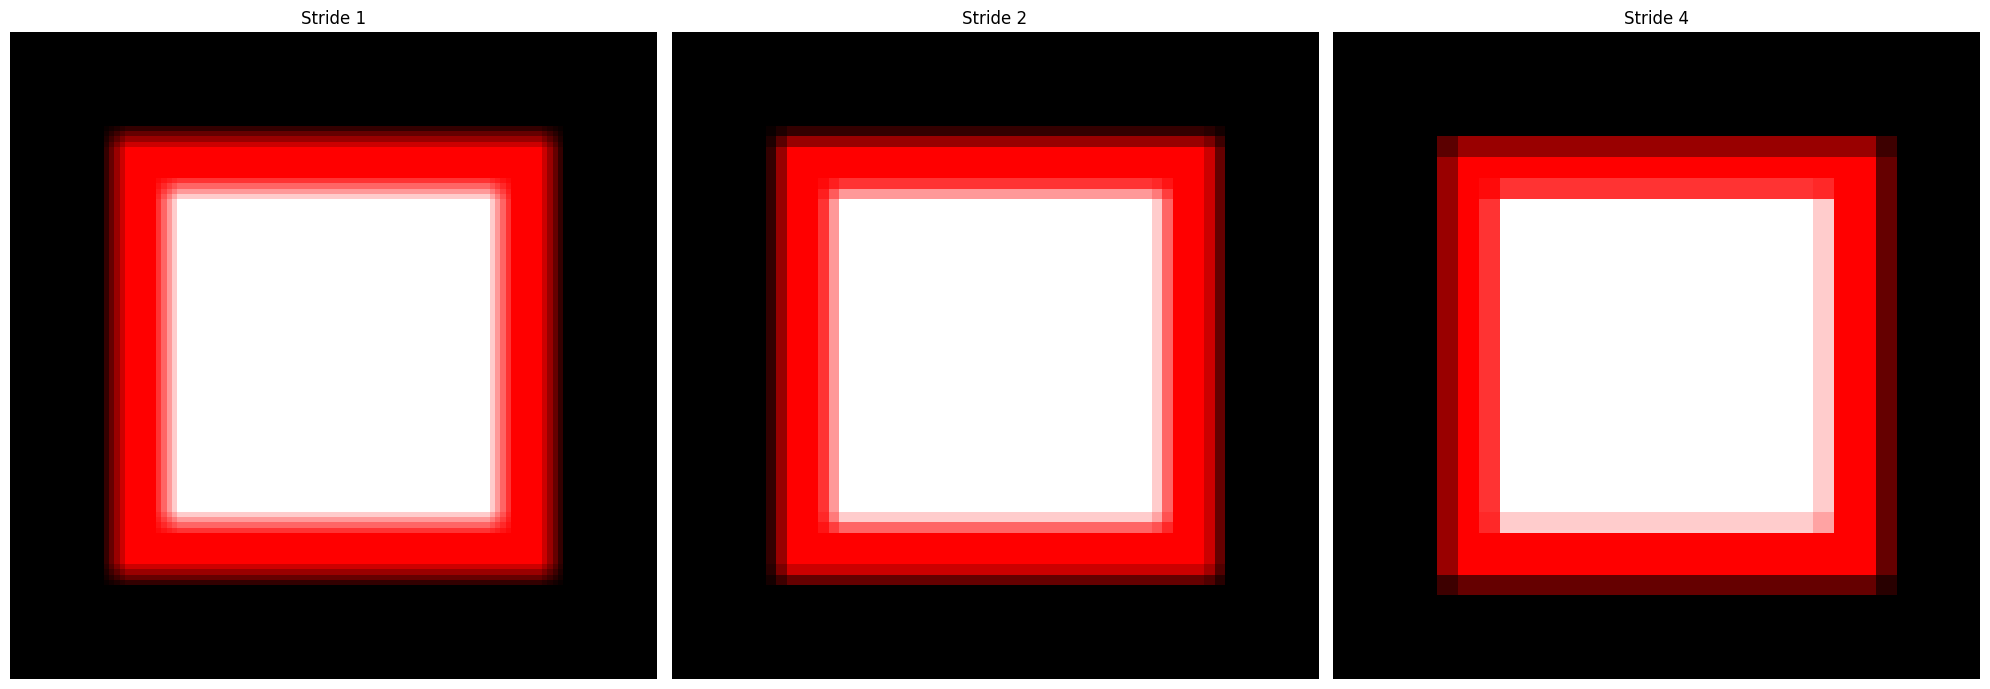

In [291]:
fig = plt.figure(figsize=(20,8))

# now we can change parameters
strides = [1, 2, 4]
for i, s in enumerate(strides, 1):
  output = conv2d(img_sq, filt, stride=s)
  print(f"output dimension with stride = {s}: {output.shape}")
  fig.add_subplot(1, len(strides), i)
  plt.imshow(output)
  plt.axis("off")
  plt.title(f"Stride {s}")
plt.tight_layout()
plt.show()


## We can also apply convolution leveraging library function

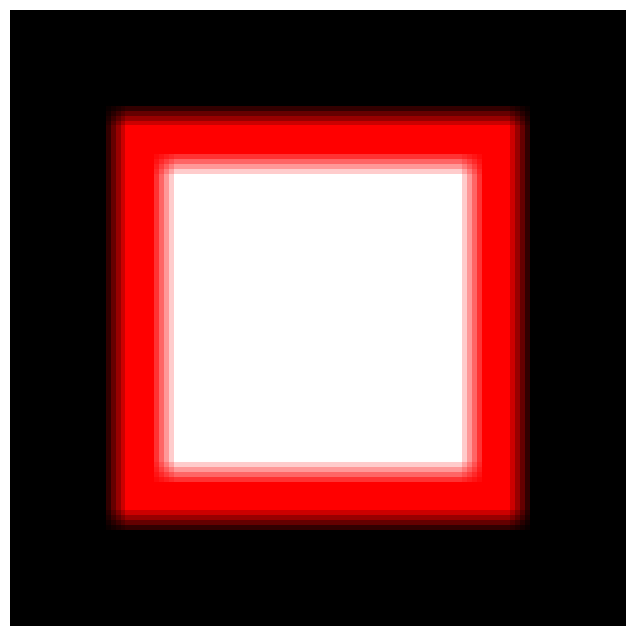

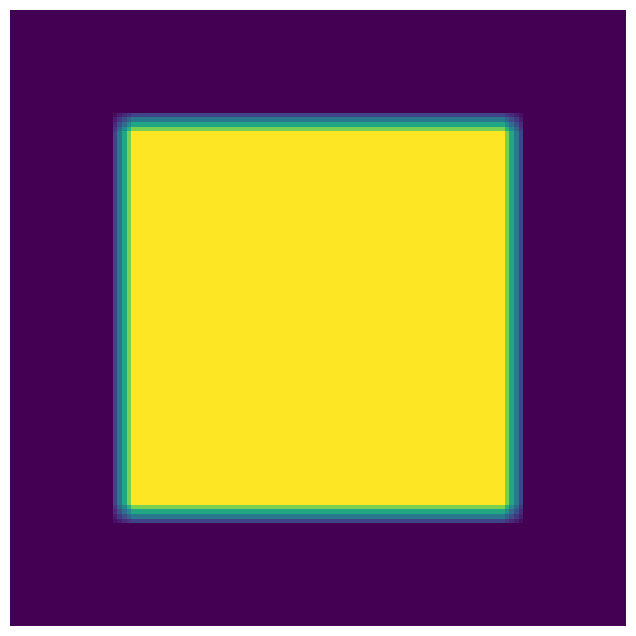

In [295]:
# with OpenCV

kernel = np.ones((5,5),np.float32)/25
blurred = cv2.filter2D(img_sq,-1,kernel)

show(blurred)

# with Scipy

blurred1 = scipy.signal.convolve2d(img_sq[:,:,0], filt)
show(blurred1)

In [296]:
# compute time to perform convolution
%timeit cv2.filter2D(img_sq,-1,filt)
print('-'*40)
# now compute time to perform our handcrafter convolution
%timeit conv2d(img_sq, filt)

123 µs ± 21.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
----------------------------------------
140 ms ± 31.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Pooling

In [300]:
def pool2d(image, kernel_size=2, stride=2, mode='max'):
  """
  Pooling 2D.
  """
  H, W = image.shape
  k = kernel_size
  outH = (H - k) // stride + 1
  outW = (W - k) // stride + 1
  out = np.zeros((outH, outW), dtype=np.float32)
  for i in range(outH):
      for j in range(outW):
          y = i * stride
          x = j * stride
          window = image[y:y+k, x:x+k]
          if mode == 'max':
              out[i, j] = np.max(window)
          else:
              out[i, j] = np.mean(window)
  return out


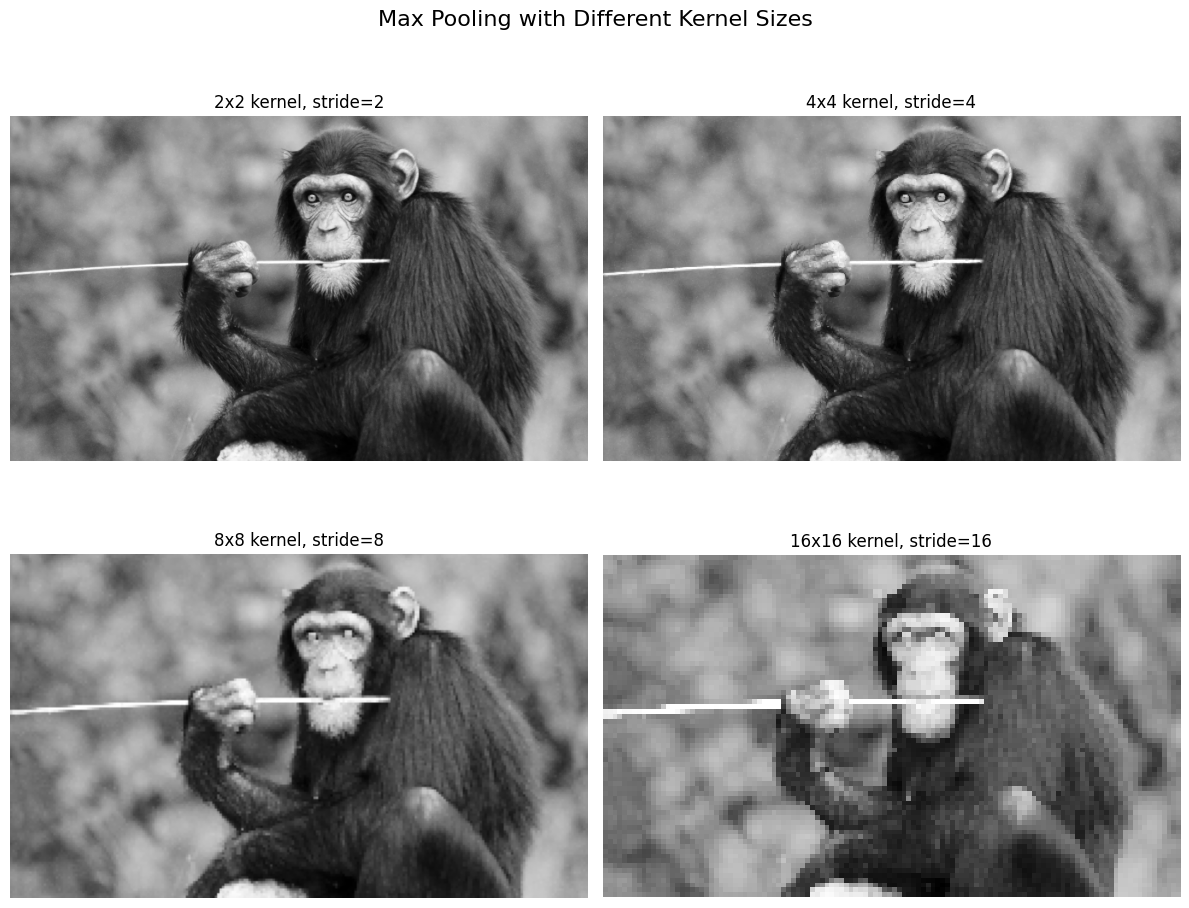

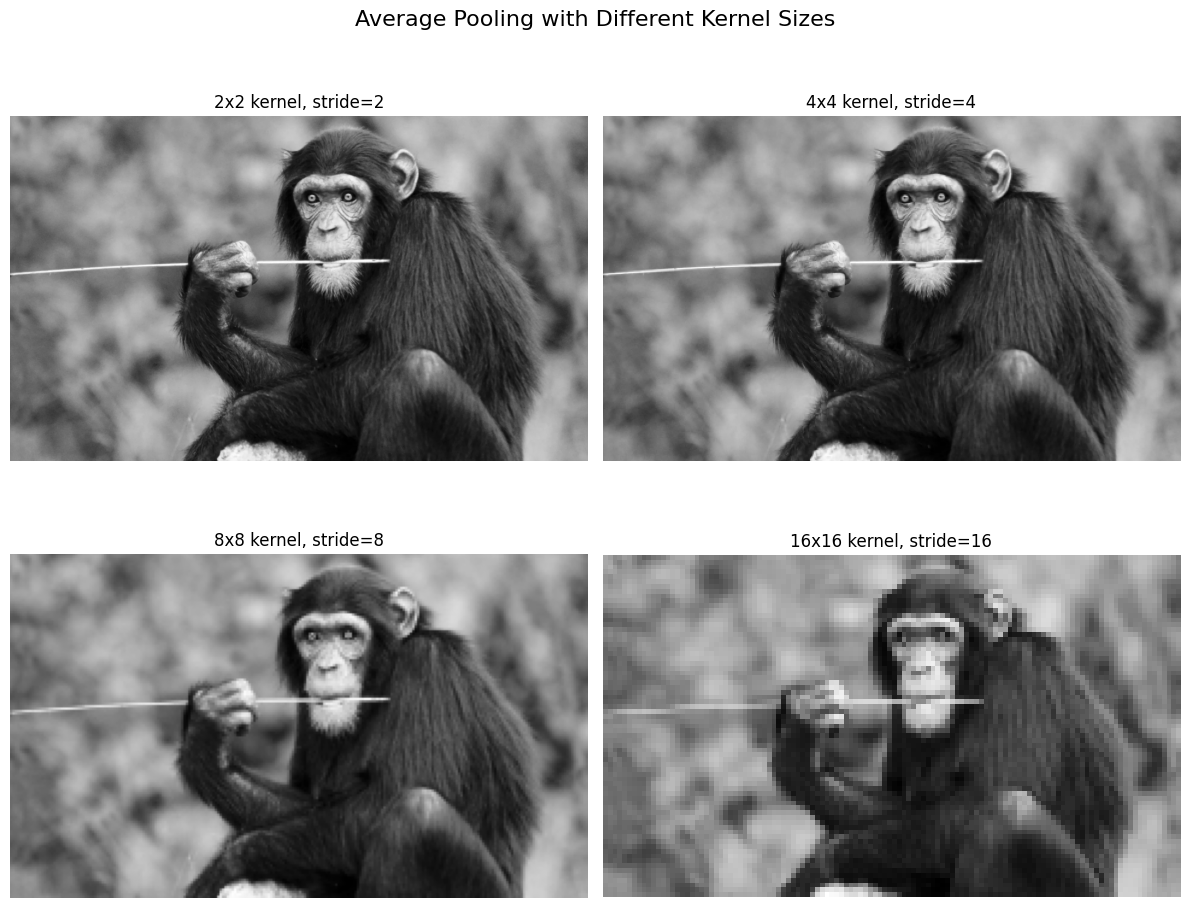

In [301]:
kernel_sizes = [2, 4, 8, 16]  # kernel sizes to test

# ----- MAX POOLING -----
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Max Pooling with Different Kernel Sizes', fontsize=16)

for ax, k in zip(axs.flat, kernel_sizes):
    pooled = pool2d(img_monkey, kernel_size=k, stride=k, mode='max')
    ax.imshow(pooled, cmap='gray')
    ax.set_title(f'{k}x{k} kernel, stride={k}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# ----- AVERAGE POOLING -----
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Average Pooling with Different Kernel Sizes', fontsize=16)

for ax, k in zip(axs.flat, kernel_sizes):
    pooled = pool2d(img_monkey, kernel_size=k, stride=k, mode='avg')
    ax.imshow(pooled, cmap='gray')
    ax.set_title(f'{k}x{k} kernel, stride={k}')
    ax.axis('off')

plt.tight_layout()
plt.show()


## Convolution for denoising

### Gaussian noise

Gaussian noise is an additive noise. In this case we manually generate and add noise to the image. We simply model a matrix with a normal distribution, generating random values

In [302]:
# Create gaussian noise
gauss_noise = np.zeros_like(img_sq, dtype=np.uint8)
cv2.randn(gauss_noise, 128, 60)                       # mean=128, std=20
img = (img_sq * 255).astype(np.uint8) if img_sq.dtype != np.uint8 else img_sq
gauss_noise = (gauss_noise * 0.5).astype(np.uint8)

# Add noise to each channel
gn_img = cv2.add(img, gauss_noise)

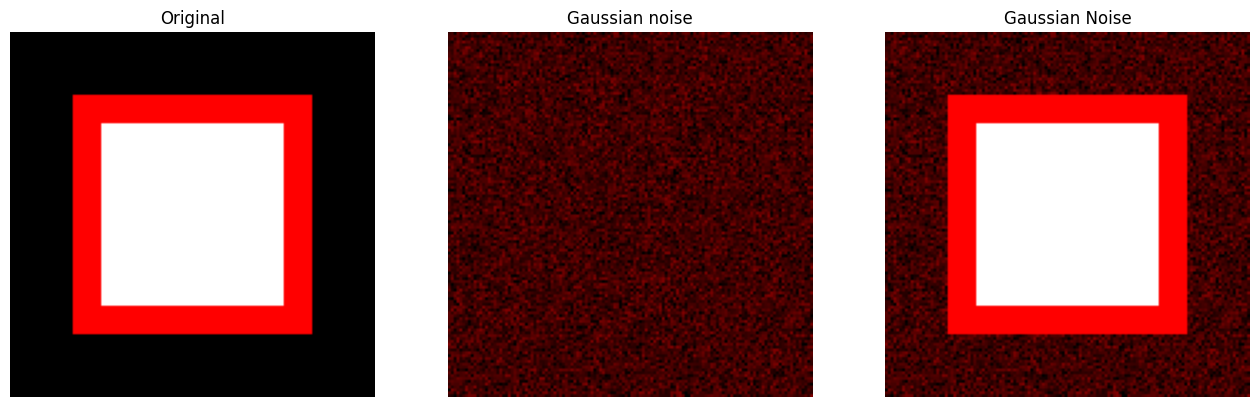

In [303]:
fig = plt.figure(figsize = (16, 12))
fig.add_subplot(1, 3, 1)
plt.imshow(img_sq)
plt.axis("off")
plt.title("Original")
fig.add_subplot(1, 3, 2)
plt.imshow(gauss_noise)
plt.axis("off")
plt.title("Gaussian noise")
fig.add_subplot(1, 3, 3)
plt.imshow(gn_img)
plt.axis("off")
plt.title("Gaussian Noise")
plt.show()



In [304]:
# test different standard deviations for noise
std_values = [20, 40, 80]
gauss_noises = [] # list to store the different amount of noise
noisy_imgs = [] # create a list to store different noisy images
for std in std_values:
  gauss_noise = np.zeros_like(img_sq, dtype=np.uint8)
  cv2.randn(gauss_noise, 128, std)                       # mean=128, std=20
  gauss_noise = (gauss_noise * 0.5).astype(np.uint8)
  gn_img = cv2.add(img, gauss_noise)
  noisy_imgs.append(gn_img)
  gauss_noises.append(gauss_noise)



In [305]:
print(len(noisy_imgs))

3


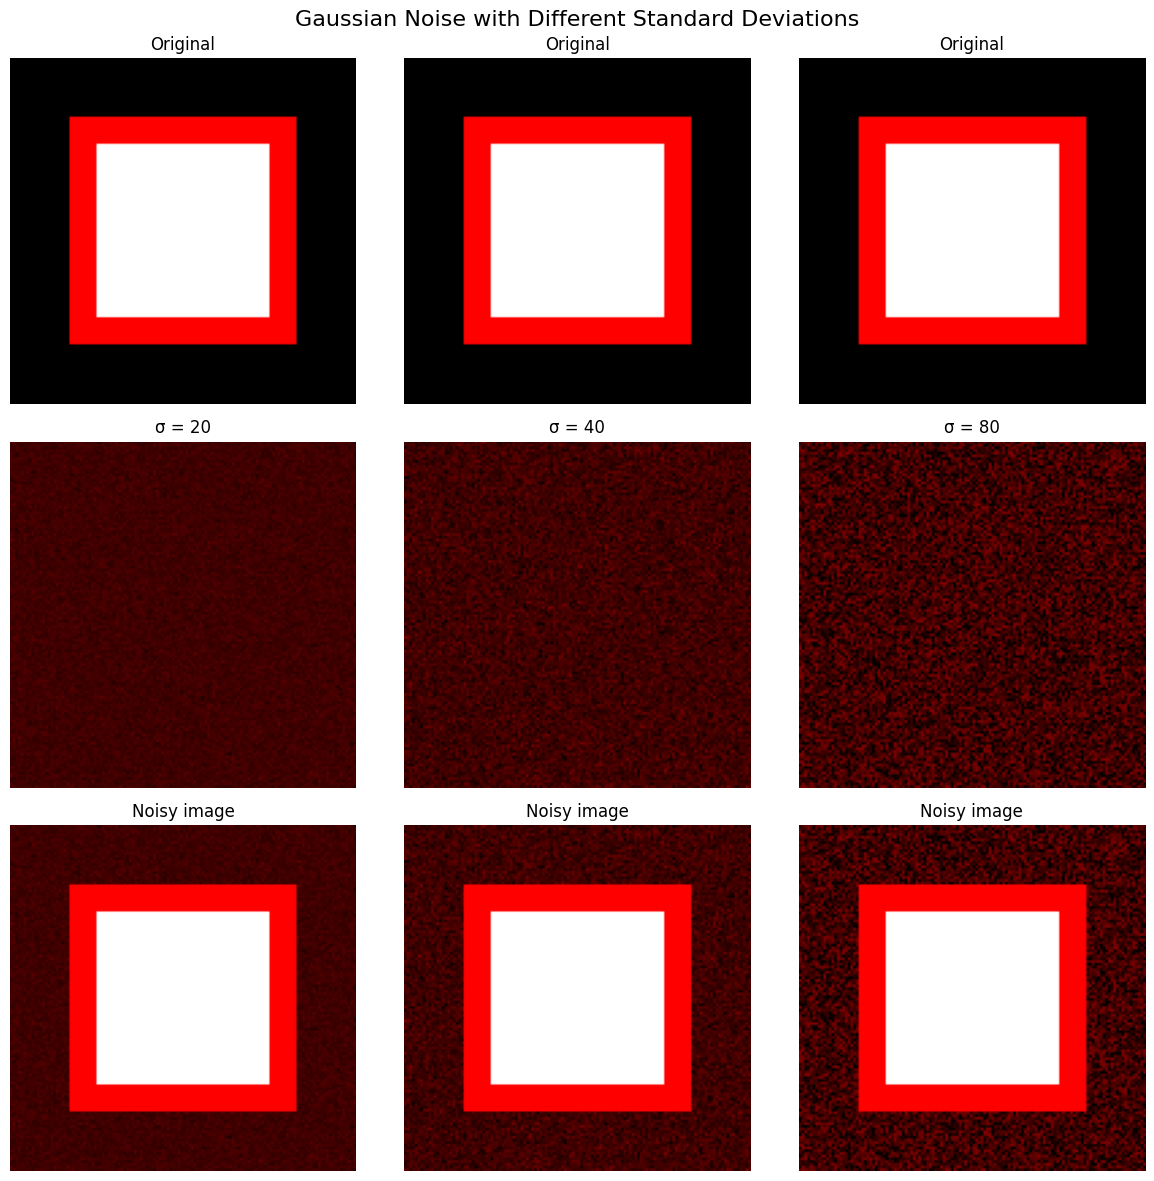

In [233]:
# visualization
# Visualization: 3×3 grid (original in first row)
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle("Gaussian Noise with Different Standard Deviations", fontsize=16)

# Row 1 — original image repeated
for ax in axs[0]:
    ax.imshow(img)
    ax.set_title("Original")
    ax.axis("off")

# Row 2 — std = 20, 40, 80
for ax, std, noise in zip(axs[1], std_values, gauss_noises):
    ax.imshow(noise)
    ax.set_title(f"σ = {std}")
    ax.axis("off")

# Row 3 — grayscale versions of same noisy images
for ax, noisy in zip(axs[2], noisy_imgs):
    ax.imshow(noisy)
    ax.set_title("Noisy image")
    ax.axis("off")

plt.tight_layout()
plt.show()

### Denoising Gaussian with Gaussian filter
Here I manually built the gaussian filter. You can build it with many values, this is just an example, but other examples can be found in internet, according to the type of the normal distribution you want to use. It is a trial and error procss

In [234]:
# select one image among the noisy ones
gn_img=noisy_imgs[0]

In [235]:
kernel = [[1, 2, 1], [2, 4, 2], [1, 2, 1]]
kernel = np.asarray (kernel)
kernel = (kernel/16).astype('float32')
blurred20 = cv2.filter2D(gn_img,-1,kernel)

We obtained a quite good result! After the filtering the image is similar to the starting one, but I didn't remove all the noise. To obtain an optimized result, an analysis in the frequency domain could be performed to undertsand the optimal kernel values.
In general, during neural networks training, this process is done automatically. During training the network learns the optimal kernel weights to remove noise.

Text(0.5, 1.0, 'Gaussian Filter')

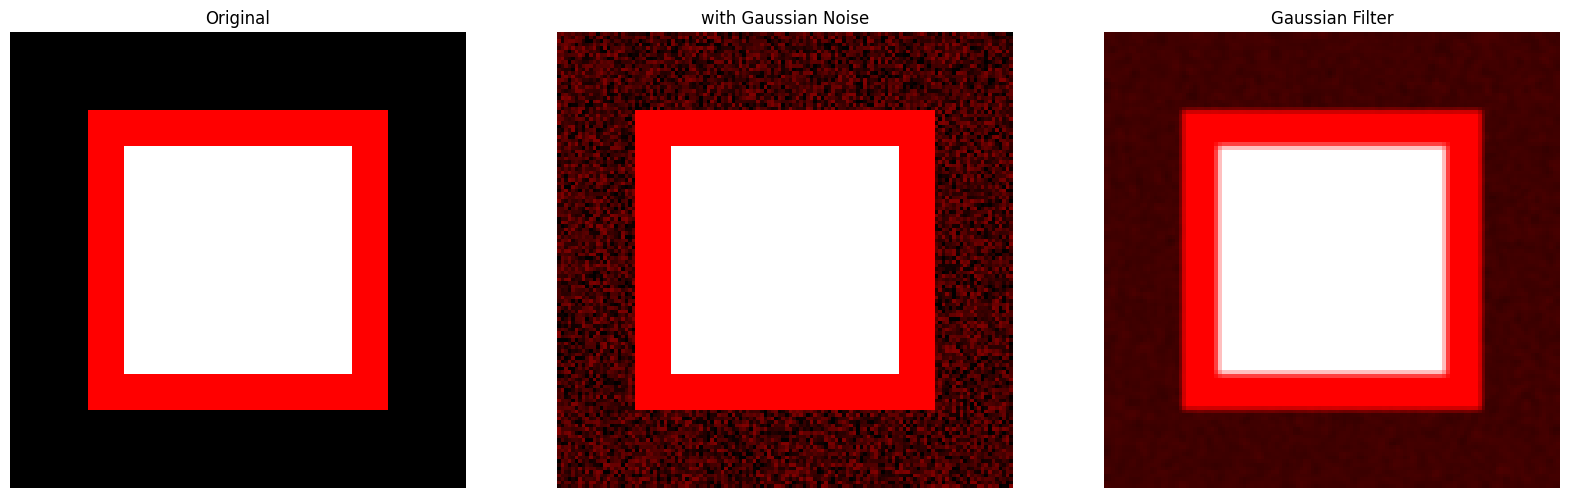

In [306]:
fig=plt.figure(figsize=(20,8))
fig.add_subplot(1,3,1)
plt.imshow(img,cmap='gray')
plt.axis("off")
plt.title("Original")

fig.add_subplot(1,3,2)
plt.imshow(gn_img,cmap='gray')
plt.axis("off")
plt.title("with Gaussian Noise")

fig.add_subplot(1,3,3)
plt.imshow(blurred20,cmap='gray')
plt.axis("off")
plt.title("Gaussian Filter")

In the previous example we manually defined the kernel to be used for filtering, but there are alredy implemented functions from cv2.

In [237]:
blurred21=cv2.GaussianBlur(gn_img,(3,3),0) # the function gets as input the noisy image and directly applies the filter, a 3x3 in this case
# if you build yourself the filter, you have higher control

Text(0.5, 1.0, 'Gaussian Filter')

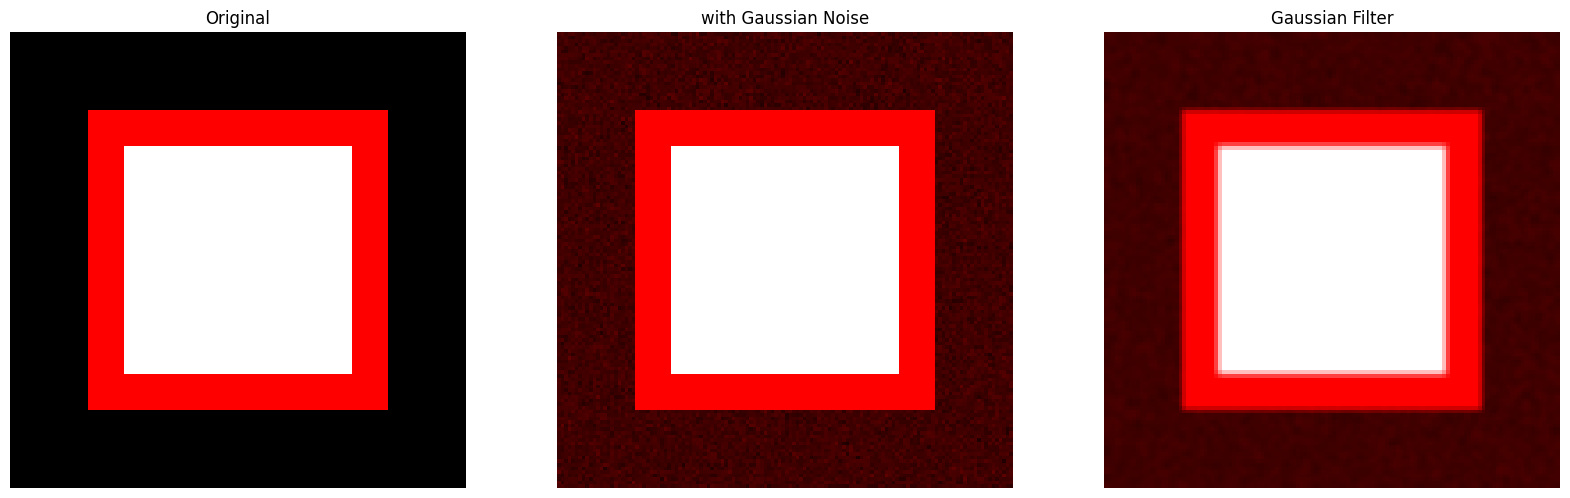

In [238]:
fig=plt.figure(figsize=(20,8))
fig.add_subplot(1,3,1)
plt.imshow(img,cmap='gray')
plt.axis("off")
plt.title("Original")

fig.add_subplot(1,3,2)
plt.imshow(gn_img,cmap='gray')
plt.axis("off")
plt.title("with Gaussian Noise")

fig.add_subplot(1,3,3)
plt.imshow(blurred21,cmap='gray')
plt.axis("off")
plt.title("Gaussian Filter")

### Poisson noise

The poisson filter is really difficult to be modeled, as it depends on the properties of the specific material of the imagfing acquisition system. There are some ways to approximate it

In [239]:
poisson_noise = np.sqrt(img) * np.random.normal(0, 1, img.shape)

pn_img = img + poisson_noise
pn_img = pn_img.astype ('uint8')

pn_img = np.random.poisson(img)
pn_img = np.clip(pn_img, 0, 255).astype(np.uint8)
print(pn_img.dtype)
print(pn_img.min(), pn_img.max())

uint8
0 255


Text(0.5, 1.0, 'Noisy image')

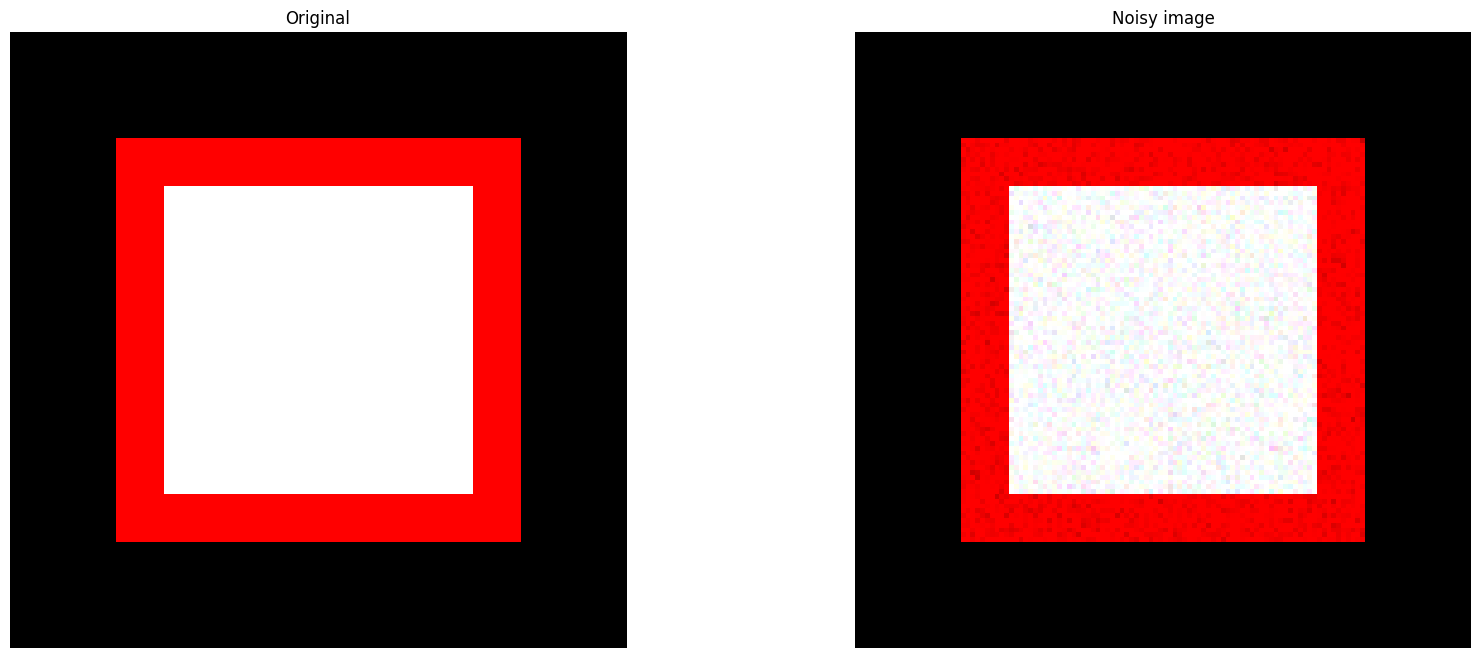

In [240]:
fig=plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.imshow(img,cmap='gray')
plt.axis("off")
plt.title("Original")


fig.add_subplot(1,2,2)
plt.imshow(pn_img,cmap='gray')
plt.axis("off")
plt.title("Noisy image")

### Denoising with mean filter

In [310]:
# We start by manually defining the kernel
size = 9
kernel = np.ones((size,size),np.float32)/ size ** 2
denoised10 = cv2.filter2D(pn_img,-1,kernel)

Text(0.5, 1.0, 'After Denoising')

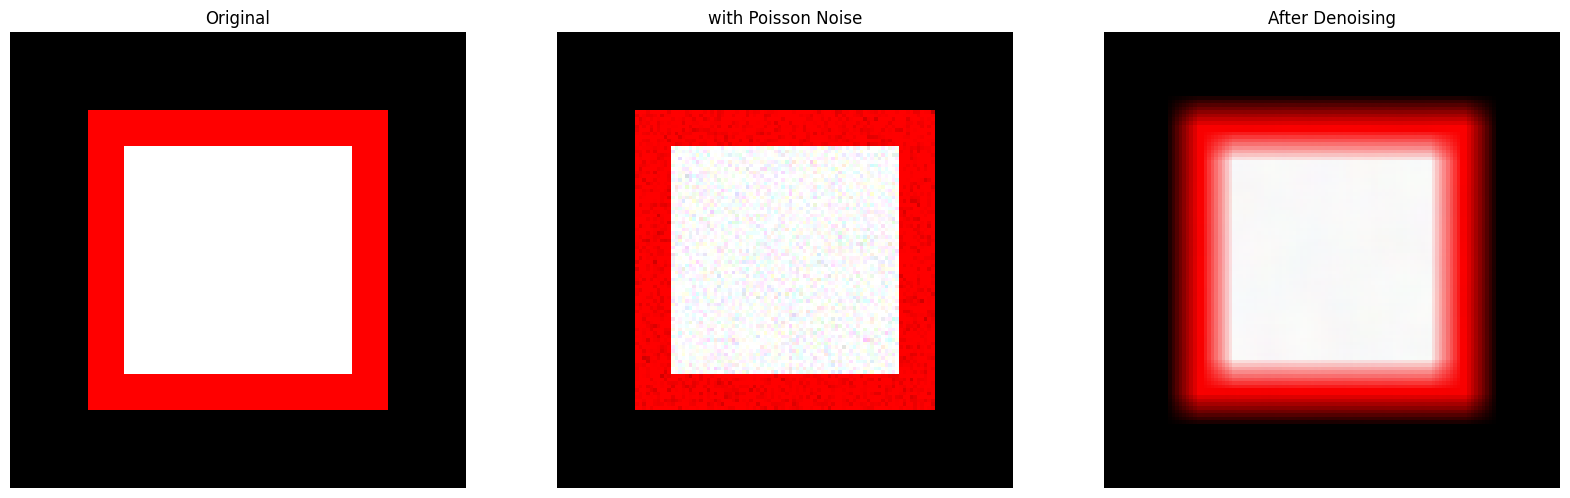

In [311]:
fig=plt.figure(figsize=(20,8))
fig.add_subplot(1,3,1)
plt.imshow(img,cmap='gray')
plt.axis("off")
plt.title("Original")

fig.add_subplot(1,3,2)
plt.imshow(pn_img,cmap='gray')
plt.axis("off")
plt.title("with Poisson Noise")

fig.add_subplot(1,3,3)
plt.imshow(denoised10,cmap='gray')
plt.axis("off")
plt.title("After Denoising")

Text(0.5, 1.0, 'After Denoising')

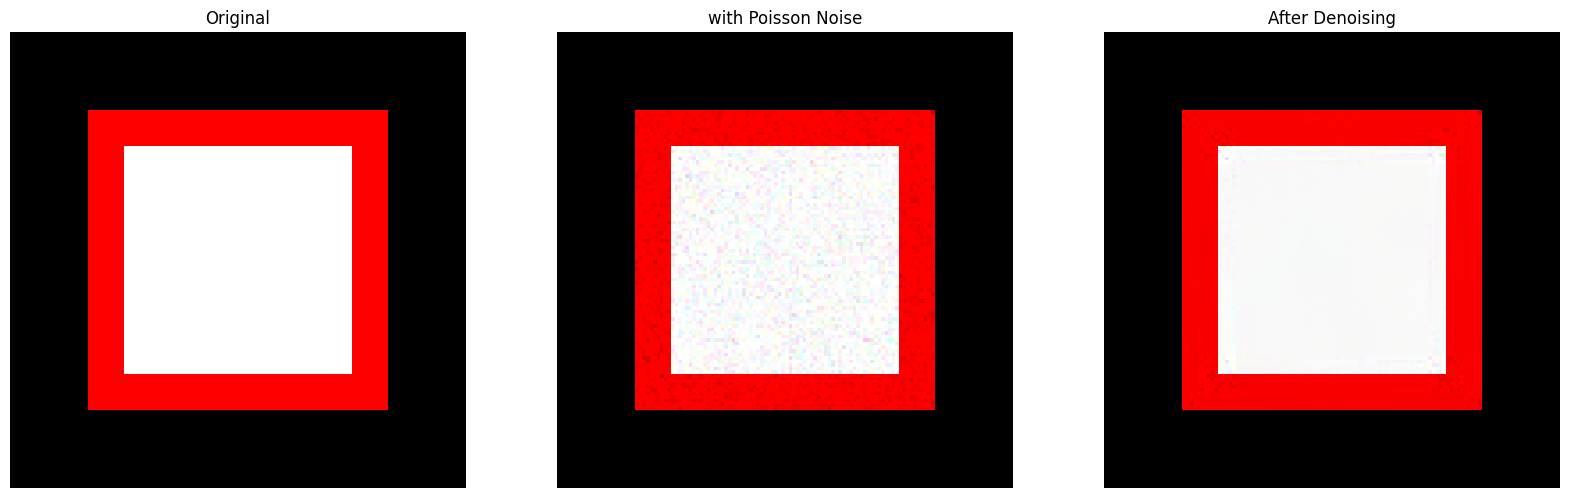

In [312]:
# This is cv2 implementation
denoised1=cv2.fastNlMeansDenoising(pn_img,None,10,10)

fig=plt.figure(figsize=(20,8))
fig.add_subplot(1,3,1)
plt.imshow(img,cmap='gray')
plt.axis("off")
plt.title("Original")

fig.add_subplot(1,3,2)
plt.imshow(pn_img,cmap='gray')
plt.axis("off")
plt.title("with Poisson Noise")

fig.add_subplot(1,3,3)
plt.imshow(denoised1,cmap='gray')
plt.axis("off")
plt.title("After Denoising")

# Salt and Pepper
You can add salt and pepper noise to your image using a randomic function. Specifically, in this case we use only two randomic values, 0 (pepper) and 255 (salt)

In [317]:
# now we add salt and pepper noise to our image
# define the porportion of pixels we want to make noisy
amount = 0.002 # 0.4% of pixels become noisy
s_vs_p = 0.5 # half pixels salt and half pepper
img_spn = np.copy(img)
is_color = (img.ndim == 3)
row, col = img.shape[:2]

# Salt noise (white pixels)
num_salt = int(np.ceil(amount * img.size * s_vs_p))
# generate random coordinates for salt
coords = [np.random.randint(0, i - 1, int(num_salt)) for i in (row, col)]
print(coords)
print(coords[0].shape)
if is_color:
    img_spn[coords[0], coords[1], :] = 255 # salt
else:
    img_spn[coords[0], coords[1]] = 255
# repeat for pepper
num_pepper = int(np.ceil(amount * img.size * s_vs_p))
coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in (row, col)]
if is_color:
    img_spn[coords[0], coords[1], :] = 0 # pepper
else:
  img_spn[coords[0], coords[1]] = 0



[array([ 15,  71, 122,  60,  57,  21,   2,  90,  26,  12,  69,  92,  52,
        60,  64,  61,   3,  96,  62,  18,  70, 126,  12,  14,  77,   7,
         1, 122,   1,  36, 125,  39,  52,  27,  58, 118, 100,  86, 109,
       107,  64,   3,  94,  10,  56,  13,  33,  94,  38,  83]), array([ 16,  68, 100,  39,  54,  71, 106,  88,   0,  37,   4,   6, 105,
        49,  37, 109,  44,  36,  27,  60,  46,  38, 106,  22,  96, 126,
       123,  41,  15,  95, 111,  62,  66, 121,  69,  75,  36, 100,  58,
        18,  15,  98,  57,  35,   4,  75, 115,  21,   8,  62])]
(50,)


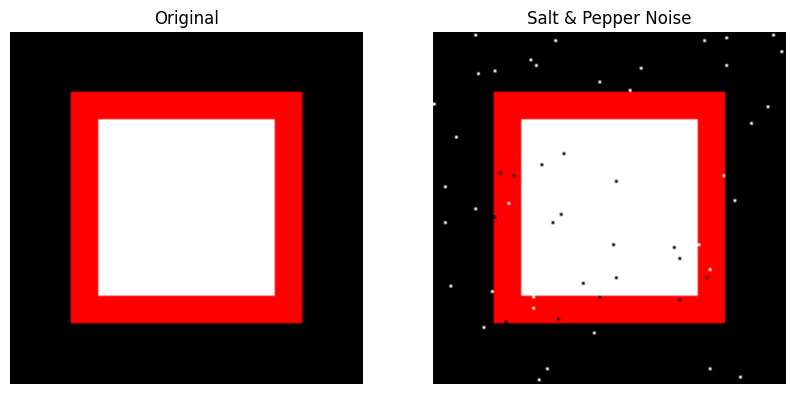

In [318]:


plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(img); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img_spn); plt.title("Salt & Pepper Noise"); plt.axis('off')
plt.show()

Denoising using Gaussian filter

In [319]:
blurred3=cv2.GaussianBlur(img_spn,(3,3),0)

Text(0.5, 1.0, 'Gaussian Filter')

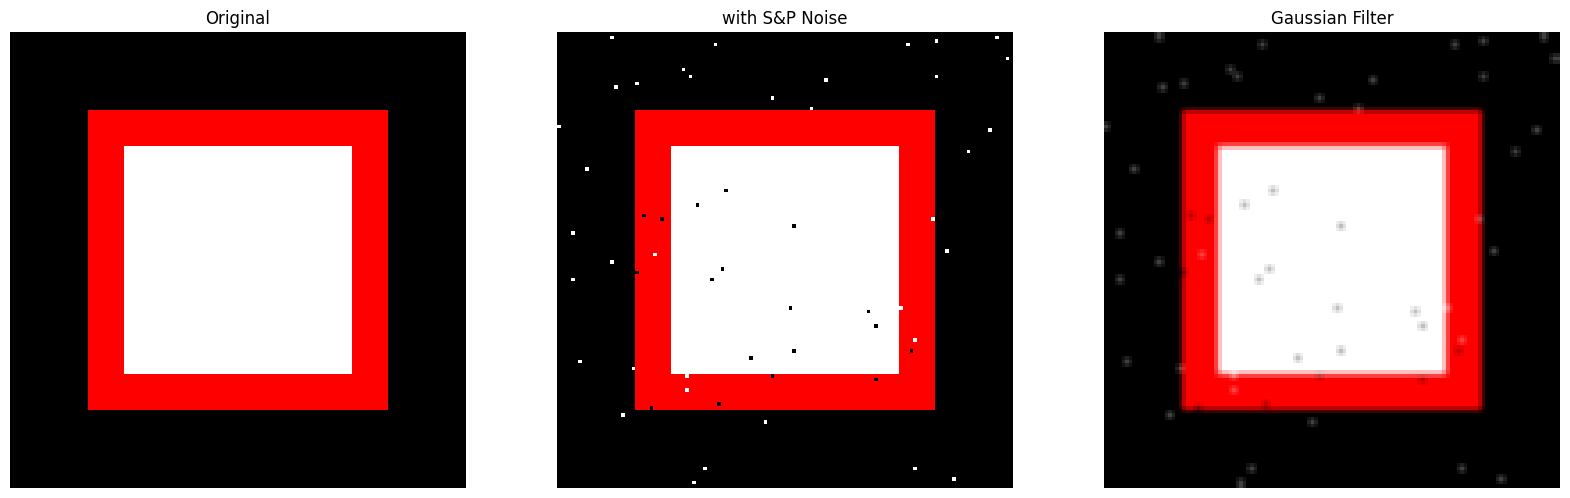

In [320]:
fig=plt.figure(figsize=(20,8))

fig.add_subplot(1,3,1)
plt.imshow(img,cmap='gray')
plt.axis("off")
plt.title("Original")

fig.add_subplot(1,3,2)
plt.imshow(img_spn,cmap='gray')
plt.axis("off")
plt.title("with S&P Noise")

fig.add_subplot(1,3,3)
plt.imshow(blurred3,cmap='gray')
plt.axis("off")
plt.title("Gaussian Filter")

Denoising using median filter

In [321]:
blurred31=cv2.medianBlur(img_spn,3)

Text(0.5, 1.0, 'Median Filter')

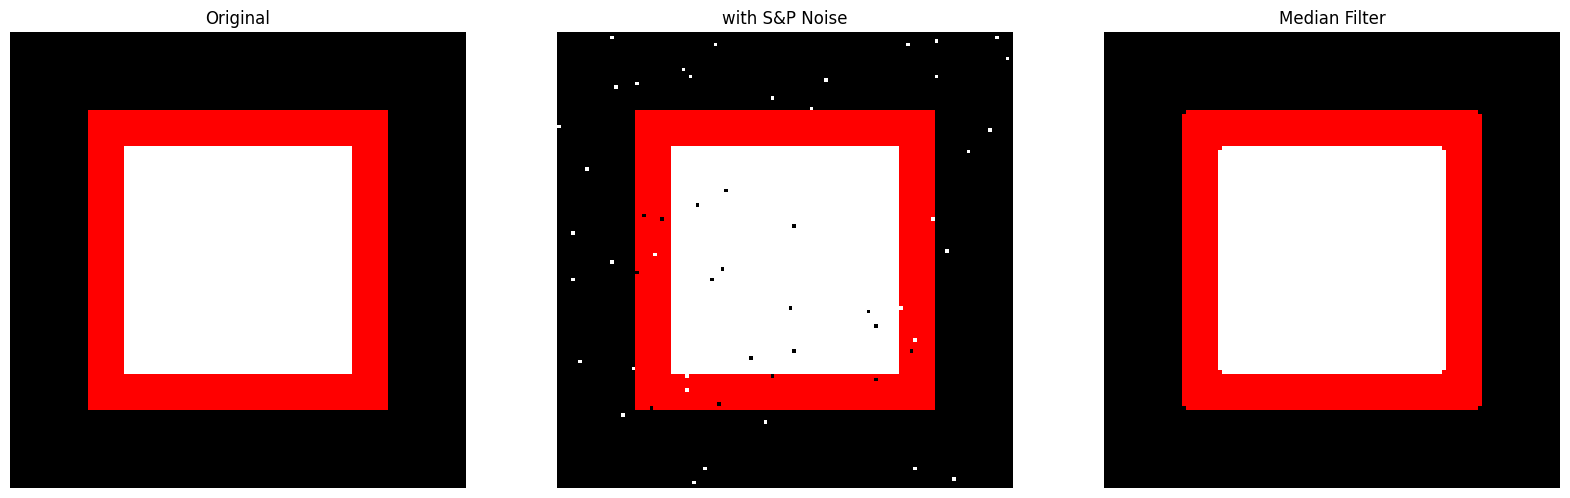

In [322]:
fig=plt.figure(figsize=(20,8))
fig.add_subplot(1,3,1)
plt.imshow(img,cmap='gray')
plt.axis("off")
plt.title("Original")

fig.add_subplot(1,3,2)
plt.imshow(img_spn,cmap='gray')
plt.axis("off")
plt.title("with S&P Noise")

fig.add_subplot(1,3,3)
plt.imshow(blurred31,cmap='gray')
plt.axis("off")
plt.title("Median Filter")

# Homomorphic filter
to deal with multiplicative noise

In [268]:
img = cv2.imread('images/person.png', cv2.IMREAD_GRAYSCALE)

In [269]:
hh, ww = img.shape[:2]

# take ln of image
img_log = np.log(np.float64(img), dtype=np.float64)

# do dft saving as complex output
dft = np.fft.fft2(img_log, axes=(0,1))

# apply shift of origin to center of image
dft_shift = np.fft.fftshift(dft)

# create black circle on white background for high pass filter
#radius = 3
radius = 13
mask = np.zeros_like(img, dtype=np.float64)
cy = mask.shape[0] // 2
cx = mask.shape[1] // 2
cv2.circle(mask, (cx,cy), radius, 1, -1)
mask = 1 - mask

# antialias mask via blurring
mask = cv2.GaussianBlur(mask, (47,47), 0)

# apply mask to dft_shift
dft_shift_filtered = np.multiply(dft_shift,mask)

# shift origin from center to upper left corner
back_ishift = np.fft.ifftshift(dft_shift_filtered)

# do idft saving as complex
img_back = np.fft.ifft2(back_ishift, axes=(0,1))

# combine complex real and imaginary components to form (the magnitude for) the original image again
img_back = np.abs(img_back)

# apply exp to reverse the earlier log
img_homomorphic = np.exp(img_back, dtype=np.float64)

# scale result
img_homomorphic = cv2.normalize(img_homomorphic, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

PET is affcted a lot by poissoninan noise. It shows we greater luminosity active areas of a tumor, therefore some artifact si created.

Text(0.5, 1.0, 'Homomorphic Filter')

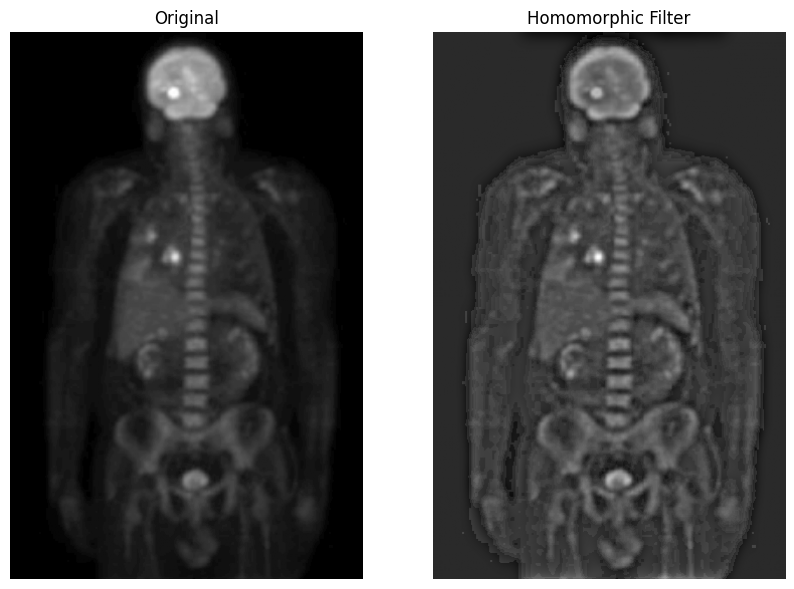

In [270]:
fig=plt.figure(figsize=(10,8))
fig.add_subplot(1,2,1)
plt.imshow(img,cmap='gray')
plt.axis("off")
plt.title("Original")

fig.add_subplot(1,2,2)
plt.imshow(img_homomorphic,cmap='gray')
plt.axis("off")
plt.title("Homomorphic Filter")